# RNN Tweet NLP

In [253]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string

import seaborn as sns
from collections import Counter

from wordcloud import WordCloud

import nltk
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Chohb/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [254]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Data Inspection

In [255]:
train

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [256]:
print("Missing Train Entries")
for i in list(train.columns):
    print(i,str(train[i].isna().sum()/train.shape[0]*100)+'%')
print("\n")
print("Missing Test Entries")
for i in list(test.columns):
    print(i,str(test[i].isna().sum()/test.shape[0]*100)+'%')

Missing Train Entries
id 0.0%
keyword 0.8012610009194797%
location 33.27203467752528%
text 0.0%
target 0.0%


Missing Test Entries
id 0.0%
keyword 0.796812749003984%
location 33.86454183266932%
text 0.0%


We will have to address the missing location values.

In [257]:
train['location'][train['location'].notna()]

31                         Birmingham
32      Est. September 2012 - Bristol
33                             AFRICA
34                   Philadelphia, PA
35                         London, UK
                    ...              
7575                               TN
7577           #NewcastleuponTyne #UK
7579                Vancouver, Canada
7580                          London 
7581                          Lincoln
Name: location, Length: 5080, dtype: object

Brief inspection of 'location', it is horribly messy. 33% of its entries are missing. Of the entries present, they are very inconsistent and would require an entirely separate NLP model to try and get any valuable information from them. <br>
We will drop the entire column for now.

In [258]:
train[train['keyword'] != 'None']['keyword'].unique()

array([nan, 'ablaze', 'accident', 'aftershock', 'airplane%20accident',
       'ambulance', 'annihilated', 'annihilation', 'apocalypse',
       'armageddon', 'army', 'arson', 'arsonist', 'attack', 'attacked',
       'avalanche', 'battle', 'bioterror', 'bioterrorism', 'blaze',
       'blazing', 'bleeding', 'blew%20up', 'blight', 'blizzard', 'blood',
       'bloody', 'blown%20up', 'body%20bag', 'body%20bagging',
       'body%20bags', 'bomb', 'bombed', 'bombing', 'bridge%20collapse',
       'buildings%20burning', 'buildings%20on%20fire', 'burned',
       'burning', 'burning%20buildings', 'bush%20fires', 'casualties',
       'casualty', 'catastrophe', 'catastrophic', 'chemical%20emergency',
       'cliff%20fall', 'collapse', 'collapsed', 'collide', 'collided',
       'collision', 'crash', 'crashed', 'crush', 'crushed', 'curfew',
       'cyclone', 'damage', 'danger', 'dead', 'death', 'deaths', 'debris',
       'deluge', 'deluged', 'demolish', 'demolished', 'demolition',
       'derail', 'der

#### Inspect text

In [259]:
for i in train['text'].head(10):
    print(i)

Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all
Forest fire near La Ronge Sask. Canada
All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected
13,000 people receive #wildfires evacuation orders in California 
Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school 
#RockyFire Update => California Hwy. 20 closed in both directions due to Lake County fire - #CAfire #wildfires
#flood #disaster Heavy rain causes flash flooding of streets in Manitou, Colorado Springs areas
I'm on top of the hill and I can see a fire in the woods...
There's an emergency evacuation happening now in the building across the street
I'm afraid that the tornado is coming to our area...


#### Notable changes
Firstly, we should transfer all hashtags into a new column and remove them. These give valuable information to the nature of the post. <br>
Then, clean up the rest of the text. <br>
Lastly, clean keywords

In [260]:

#   Function for cleaning up text specifically
def clean_text(text):
    #   lowercase
    text = text.lower()

    #   remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)

    #   remove @ mentions
    text = re.sub(r'@\w+', '', text)

    #   remove punctuation
    text = text.translate(str.maketrans('','',string.punctuation))

    #   remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()

    return text
    



def clean(df):
    #   Drop location entirely
    df.drop(columns=['location'],axis=1,inplace=True)


    #   Fill keyword NA's with 'none'
    df['keyword'] = df['keyword'].fillna('None')


    #           Text
    #   Move hashtags to new column
    df['hashtag'] = df['text'].str.findall(r'#\w+')
    df['hashtag'] = df['hashtag'].apply(lambda tags: [tag.replace('#', '').lower() for tag in tags])  #   remove '#' char, lowercase
    df['text'] = df['text'].str.replace(r'#\w+', '', regex=True)
    
    #   Clean text
    df['text'] = df['text'].apply(clean_text)

    #   Clean keyword
    #       Strangly, some spaces are replaced with '%20'
    df['keyword'] = df['keyword'].str.replace('%20', ' ', regex=False)

    return df

train = clean(train)
test = clean(test)

In [261]:
train.head(5)

,id,keyword,text,target,hashtag
0,1,None,our deeds are the reason of this may allah for...,1,[earthquake]
1,4,None,forest fire near la ronge sask canada,1,[]
2,5,None,all residents asked to shelter in place are be...,1,[]
3,6,None,13000 people receive evacuation orders in cali...,1,[wildfires]
4,7,None,just got sent this photo from ruby as smoke fr...,1,"[alaska, wildfires]"


## Visualize
Looks good! Before embedding, let's visualize the data

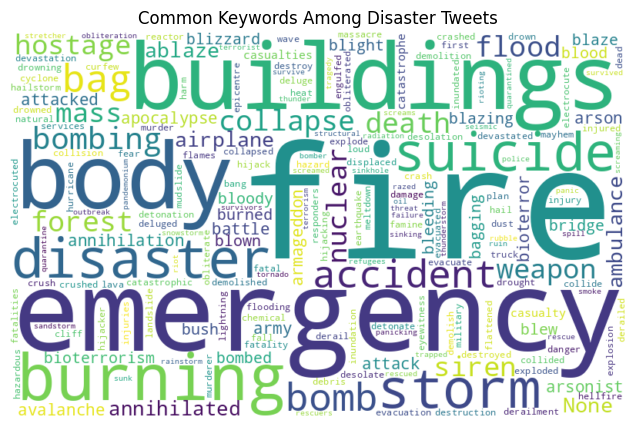

In [262]:
all_text = ' '.join(train[train['target'] == 1]['keyword'].drop_duplicates())

wordcloud = WordCloud(width=800, height=500, background_color='white').generate(all_text)

# Display it
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Keywords Among Disaster Tweets')
plt.show()

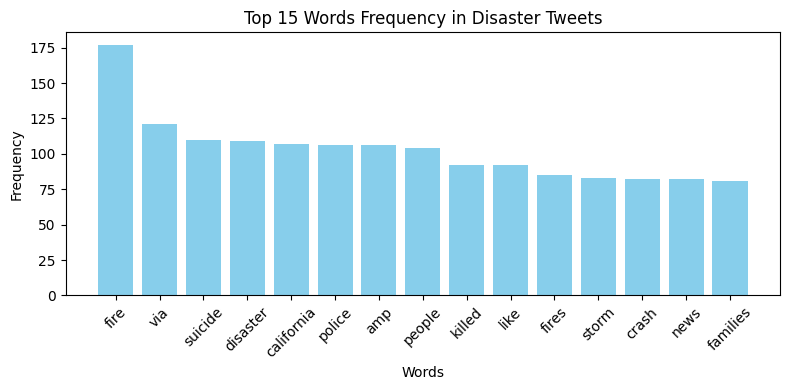

In [263]:
stop_words = set(stopwords.words('english'))

pos_twts = train[train['target'] == 1]['text']

words = []
for tweet in pos_twts:
    #   Add non-stopwords 
    words.extend([word for word in tweet.lower().split() if word not in stop_words])

word_counts = Counter(words)
sorted_words_freq = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)
words_sorted = [w for w, _ in sorted_words_freq[:15]]
freqs_sorted = [f for _, f in sorted_words_freq[:15]]

plt.figure(figsize=(8, 4))
plt.bar(words_sorted, freqs_sorted, color='skyblue')
plt.title('Top 15 Words Frequency in Disaster Tweets')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

It's good to recognize the most common words and keywords within disaster tweets (target=1)<br>
Our RNN model will not solely focus on these hotwords as it takes in the sequence of words that makeup the tweets. <br>

### Tokenization and Preprocessing

In [264]:
from sklearn.preprocessing import LabelEncoder

def tok(df):
    # Tokenize 'text' column
    text_tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')  #   oov_token: tokenizer accounts for unknown words
    text_tokenizer.fit_on_texts(df['text'])
    text_sequences = text_tokenizer.texts_to_sequences(df['text'])
    texts = pad_sequences(text_sequences, maxlen=50, padding='post')

    #   Label encode keywords
    #       Because there's only 1 keyword per row, we can label encode
    keyword_encoder = LabelEncoder()
    keyword_encoded = keyword_encoder.fit_transform(df['keyword'])
    keywords = keyword_encoded.reshape(-1, 1)    # Reshape

    #   Tokenize hashtag
    all_hashtags = [tag for tags in df['hashtag'] for tag in tags]
    hashtag_tokenizer = Tokenizer(num_words=2000, oov_token='<OOV>')
    hashtag_tokenizer.fit_on_texts(all_hashtags)

    hashtag_sequences = hashtag_tokenizer.texts_to_sequences(df['hashtag'])
    hashtags = pad_sequences(hashtag_sequences, maxlen=5, padding='post')

    return texts,keywords,hashtags

#Split 
from sklearn.model_selection import train_test_split
train,val = train_test_split(train,test_size=0.2,random_state=15)

train_text,train_keywords,train_hashtags = tok(train)
val_text,val_keywords,val_hashtags = tok(val)
test_text,test_keywords,test_hashtags = tok(test)


In [265]:
from tensorflow.keras.layers import Input, Embedding, GRU, Dense, Flatten, Concatenate
from tensorflow.keras.models import Model

# Replace with your actual vocab sizes
NUM_KEYWORDS = int(train_keywords.max()) + 1
NUM_HASHTAGS = int(train_hashtags.max()) + 1

# Define model inputs
text_input = Input(shape=(50,))
keyword_input = Input(shape=(1,))
hashtag_input = Input(shape=(5,))

# Embedding and GRU for text
text_emb = Embedding(input_dim=10000, output_dim=64)(text_input)
text_gru = GRU(64)(text_emb)

# Embedding for keyword
keyword_emb = Embedding(input_dim=NUM_KEYWORDS, output_dim=8)(keyword_input)
keyword_flat = Flatten()(keyword_emb)

# Embedding for hashtags
hashtag_emb = Embedding(input_dim=2000, output_dim=8)(hashtag_input)
hashtag_flat = Flatten()(hashtag_emb)

# Combine all features
merged = Concatenate()([text_gru, keyword_flat, hashtag_flat])
output = Dense(1, activation='sigmoid')(merged)

# Build and compile model
model = Model(inputs=[text_input, keyword_input, hashtag_input], outputs=output)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train
model.fit(
    [train_text, train_keywords, train_hashtags],
    train['target'],
    epochs=5,
    batch_size=32,
    validation_split=0.2
)


Epoch 1/5


TypeError: in user code:

    File "c:\Users\Chohb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\Chohb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\Chohb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\Chohb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1085, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\Chohb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py", line 1179, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\Chohb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\compile_utils.py", line 605, in update_state
        metric_obj.update_state(y_t, y_p, sample_weight=mask)
    File "c:\Users\Chohb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\utils\metrics_utils.py", line 77, in decorated
        update_op = update_state_fn(*args, **kwargs)
    File "c:\Users\Chohb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\metrics\base_metric.py", line 140, in update_state_fn
        return ag_update_state(*args, **kwargs)
    File "c:\Users\Chohb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\metrics\base_metric.py", line 723, in update_state  **
        matches = ag_fn(y_true, y_pred, **self._fn_kwargs)

    TypeError: 'str' object is not callable


In [ ]:
# Suppose you have these validation arrays and labels:
# text_padded_val, keyword_encoded_val, hashtag_padded_val, y_val

loss, accuracy = model.evaluate(
    [val_text, val_keywords, val_hashtags],
    val['target']
)
print(f"Validation Loss: {loss:.4f}, Validation Accuracy: {accuracy:.4f}")
